# Project in Introduction to Computational Statistics

## Contributors:

| | Lastname | Firstname | Matriculation Number|
| --- | ------------------ | ------------------ | -------------------- |
| 1 | Kürnsteiner | David | k11820336 |
| 2 | Peinthor | Christian | k11815592 |
| 3 | Ramoser | Elias | k11918558 |
| 4 | Storz | Georg | k11918811 |

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import anderson, cramervonmises, chisquare, shapiro
from statsmodels.stats.diagnostic import lilliefors
from statistics import mode
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures

In [2]:
df1 = pd.read_excel('Project Data.xlsx', 'LOMA LARGA')
df2 = pd.read_excel('Project Data.xlsx', '2 NORTE')
df3 = pd.read_excel('Project Data.xlsx', 'ALMENDRAL')
df4 = pd.read_excel('Project Data.xlsx', 'CORDILLERA')

In [3]:
rename_dict_spa = {'Concentración (copias/mL)': 'concentration', 'Tasa incidencia activos': 'active_incidence', 'Tasa incidencia actual': 'current_incidence', 'Casos activos': 'active_cases', 'Casos actuales': 'actual_cases'}
rename_dict_eng = {'Concentration ': 'concentration', 'Active Incidence Rate ': 'active_incidence', 'Actual Incidence Rate': 'current_incidence', 'Active Cases': 'active_cases', 'Actual Cases': 'actual_cases'}
df1 = df1[['Concentración (copias/mL)', 'Tasa incidencia activos', 'Tasa incidencia actual', 'Casos activos', 'Casos actuales']]
df1 = df1.rename(columns=rename_dict_spa)
df2 = df2[['Concentración (copias/mL)', 'Tasa incidencia activos', 'Tasa incidencia actual', 'Casos activos', 'Casos actuales']]
df2 = df2.rename(columns=rename_dict_spa)
df3 = df3[['Concentración (copias/mL)', 'Tasa incidencia activos', 'Tasa incidencia actual', 'Casos activos', 'Casos actuales']]
df3 = df3.rename(columns=rename_dict_spa)
df4 = df4[['Concentration ', 'Active Incidence Rate ', 'Actual Incidence Rate', 'Active Cases', 'Actual Cases']]
df4 = df4.rename(columns=rename_dict_eng)

In [4]:
resid_print_out = {}

In [5]:
def get_residuals(Y_true, Y_predicted):
    return Y_true - Y_predicted
    
def check_normal_distribution(x):
    # Used significance level of alpha=0.05
    res_ad = anderson(x, dist='norm')
    reject_ad = res_ad.statistic > res_ad.critical_values[2]
    
    res_cvm = cramervonmises(x, 'norm')
    reject_cvm = res_cvm.pvalue < 0.05
    
    res_lillie = lilliefors(x, 'norm')
    reject_lillie = res_lillie[1] < 0.05
    
    res_pearson = chisquare(x)
    reject_pearson = res_pearson[1] < 0.05
    
    res_shapiro = shapiro(x)
    reject_shapiro = res_shapiro[1] < 0.05
    
    majority_vote = mode([reject_ad, reject_cvm, reject_lillie, reject_pearson, reject_shapiro])

    return majority_vote

def add_to_residual_print_out(name, df, X, Y, predict):
    residuals = get_residuals(Y, predict(X))
    majority_vote = check_normal_distribution(residuals)
    global resid_print_out
    resid_print_out[name] = f'Rejection: {majority_vote}'


def make_lin_reg(X_col, Y_col, X_name, Y_name):
    fig, axs = plt.subplots(2,2, figsize=(10, 6))
    axs = axs.ravel()
    fig.subplots_adjust(hspace = .5, wspace=.5)
    for df, name, index in zip([df1, df2, df3, df4], ['LOMA LARGA', '2 NORTE', 'ALMENDRAL', 'CORDILLERA'], [0,1,2,3]):
        X = df[X_col].to_numpy()
        Y = df[Y_col].to_numpy()
        lm = np.polyfit(X, Y, 1)
        predict = np.poly1d(lm)
        new_x = np.linspace(min(X), max(X))
        new_y = predict(new_x)
        axs[index].scatter(X, Y)
        axs[index].plot(new_x, new_y, color='red')
        axs[index].set_title(name)
        axs[index].set_xlabel(X_name)
        axs[index].set_ylabel(Y_name)
        add_to_residual_print_out(f'Linear regression {X_name} --> {Y_name}: {name}', df, X, Y, predict) # For later task to check the normality of the residuals
    plt.show()
    

def make_non_lin_reg(X_col, Y_col, X_name, Y_name, degrees):
    for df, name in zip([df1, df2, df3, df4], ['LOMA LARGA', '2 NORTE', 'ALMENDRAL', 'CORDILLERA']):
        print(f'\nNon-linear Regressions with the data: {name}')
        X = df[X_col].to_numpy()
        Y = df[Y_col].to_numpy()
        fig, axs = plt.subplots(2,2, figsize=(10, 5))
        axs = axs.ravel()
        fig.subplots_adjust(hspace = .5, wspace=.5)

        for index, deg in enumerate(degrees):
            lm = np.polyfit(X, Y, deg)
            predict = np.poly1d(lm)
            new_x = np.linspace(min(X), max(X))
            new_y = predict(new_x)
            axs[index].scatter(X, Y)
            axs[index].plot(new_x, new_y, color='red')
            axs[index].set_title(name + f' (Degree: {deg})')
            axs[index].set_xlabel(X_name)
            axs[index].set_ylabel(Y_name)
            add_to_residual_print_out(f'Non linear regression (degree: {deg}) {X_name} --> {Y_name}: {name}', df, X, Y, predict) # For later task to check the normality of the residuals
        plt.show()
        

def replace_dep(X_col_before, X_col_after, Y_col, X_col_name_before, X_col_name_after, Y_col_name):
    for df, name, index in zip([df1, df2, df3, df4], ['LOMA LARGA', '2 NORTE', 'ALMENDRAL', 'CORDILLERA'], [0,2,4,6]):
        dep_var = [X_col_before, X_col_after]
        label_name = [X_col_name_before, X_col_name_after]
        fig, axs = plt.subplots(1,2, figsize=(10, 6))
        axs = axs.ravel()
        fig.subplots_adjust(hspace = .5, wspace=.5)
        for i in [0,1]:
            X = df[dep_var[i]].to_numpy()
            Y = df[Y_col].to_numpy()
            lm = np.polyfit(X, Y, 1)
            predict = np.poly1d(lm)
            new_x = np.linspace(min(X), max(X))
            new_y = predict(new_x)
            axs[i].scatter(X, Y)
            axs[i].plot(new_x, new_y, color='red')
            axs[i].set_title(name + f' ({label_name[i]})')
            axs[i].set_xlabel(label_name[i])
            axs[i].set_ylabel(Y_col_name)
            if i == 1: # the case 0 has been calculated in the linear regression case
                add_to_residual_print_out(f'Linear regression (changed dependent var) {label_name[i]} --> {Y_col_name}: {name}', df, X, Y, predict) # For later task to check the normality of the residuals
        plt.show()
    
        
def replace_indep(X_col, Y_col_before, Y_col_after, X_col_name, Y_col_name_before, Y_col_name_after):
    for df, name, index in zip([df1, df2, df3, df4], ['LOMA LARGA', '2 NORTE', 'ALMENDRAL', 'CORDILLERA'], [0,2,4,6]):
        indep_var = [Y_col_before, Y_col_after]
        label_name = [Y_col_name_before, Y_col_name_after]
        fig, axs = plt.subplots(1,2, figsize=(10, 4))
        axs = axs.ravel()
        fig.subplots_adjust(hspace = .5, wspace=.5)
        for i in [0,1]:
            X = df[X_col].to_numpy()
            Y = df[indep_var[i]].to_numpy()
            lm = np.polyfit(X, Y, 1)
            predict = np.poly1d(lm)
            new_x = np.linspace(min(X), max(X))
            new_y = predict(new_x)
            axs[i].scatter(X, Y)
            axs[i].plot(new_x, new_y, color='red')
            axs[i].set_title(name + f' ({label_name[i]})')
            axs[i].set_xlabel(X_col_name)
            axs[i].set_ylabel(label_name[i])
            if i == 1: # the case 0 has been calculated in the linear regression case
                add_to_residual_print_out(f'Linear regression (changed independent var) {X_col_name} --> {label_name[i]}: {name}', df, X, Y, predict) # For later task to check the normality of the residuals

        plt.show()
        
def make_2d_lin_reg(X_col_1, X_col_2, Y_col, X_name_1, X_name_2, Y_name):
    fig = plt.figure(figsize=(15, 10))
    for df, name, index in zip([df1, df2, df3, df4], ['LOMA LARGA', '2 NORTE', 'ALMENDRAL', 'CORDILLERA'], [0,1,2,3]):
        axs = fig.add_subplot(2, 2, index+1, projection='3d')
        X_1 = df[X_col_1].to_numpy()
        X_2 = df[X_col_2].to_numpy()
        X = np.array([X_1, X_2]).T
        Y = df[Y_col].to_numpy()
        regr = linear_model.LinearRegression()
        regr.fit(X, Y)
        new_x = np.array([np.linspace(min(X_1), max(X_1)), np.linspace(min(X_2), max(X_2))]).T
        new_y = regr.predict(new_x)
        axs.scatter3D(X[:, 0], X[:, 1], Y)
        axs.plot3D(new_x[:, 0], new_x[:, 1], new_y, color='red')
        axs.set_title(name)
        axs.set_xlabel(X_name_1)
        axs.set_ylabel(X_name_2)
        axs.set_zlabel(Y_name)
        add_to_residual_print_out(f'Linear regression ({X_name_1}, {X_name_2}) --> {Y_name}: {name}', df, X, Y, regr.predict) # For later task to check the normality of the residuals
    plt.show()
    
def make_2d_non_lin_reg(X_col_1, X_col_2, Y_col, X_name_1, X_name_2, Y_name, degrees):
    for df, name, index in zip([df1, df2, df3, df4], ['LOMA LARGA', '2 NORTE', 'ALMENDRAL', 'CORDILLERA'], [0,1,2,3]):
        print(f'\nNon-linear Regressions with the data: {name}')
        fig = plt.figure(figsize=(15,6))
        X_1 = df[X_col_1].to_numpy()
        X_2 = df[X_col_2].to_numpy()
        X = np.array([X_1, X_2]).T
        Y = df[Y_col].to_numpy()

        fig.subplots_adjust(hspace = .5, wspace=.5)
        
        
        for index, deg in enumerate(degrees):
            axs = fig.add_subplot(1,4, index+1, projection='3d')
            poly = PolynomialFeatures(degree=deg, include_bias=False)
            poly_features = poly.fit_transform(X)
            poly_reg_model = linear_model.LinearRegression()
            poly_reg_model.fit(poly_features, Y)
            new_x = np.array([np.linspace(min(X_1), max(X_1)), np.linspace(min(X_2), max(X_2))]).T
            new_y = poly_reg_model.predict(poly.fit_transform(new_x))
            axs.scatter3D(X[:, 0], X[:, 1], Y)
            axs.plot3D(new_x[:, 0], new_x[:, 1], new_y, color='red')
            axs.set_title(name + f' (Degree: {deg})')
            axs.set_xlabel(X_name_1)
            axs.set_ylabel(X_name_2)
            axs.set_zlabel(Y_name) 
            
            residuals = get_residuals(Y, poly_reg_model.predict(poly_features))
            majority_vote = check_normal_distribution(residuals)
            global resid_print_out
            resid_print_out[f'Polynomial regression (degree: {deg}) ({X_name_1}, {X_name_2}) --> {Y_name}: {name}'] = f'Rejection: {majority_vote}'
        plt.show()
        
def print_residual_analysis():
    global resid_print_out
    print('The True/False value says, if the null hypothesis should be rejected by the majority vote of five tests for normal distribution')
    print('If "True" we can reject the hypothesis that the data is normally distributed and can say that is not normally distributed.')
    print('(With alpha = 0.05)')
    print('')
    for name in resid_print_out:
        print(f'{name}: {resid_print_out[name]}')
    resid_print_out = {}

## Task 1
- Check the collinearity of CurrentIncidenceRate and ActualCases.
- Check the collinearity of ActiveIncidenceRate and ActiveCases.

In [6]:
df1.corr()

,concentration,active_incidence,current_incidence,active_cases,actual_cases
concentration,1.000000,-0.198572,-0.197320,-0.198508,-0.197131
active_incidence,-0.198572,1.000000,0.999933,1.000000,0.999931
current_incidence,-0.197320,0.999933,1.000000,0.999936,1.000000
active_cases,-0.198508,1.000000,0.999936,1.000000,0.999934
actual_cases,-0.197131,0.999931,1.000000,0.999934,1.000000


Above we can see the correlation of the variables. The range of the values is from -1 to 1 (from not to highly correlated).

Collinearity of CurrentIncidenceRate and ActualCases:   
From above we can conclude that these two variables are highly correlated (value: 1) and therefore they are collinear!
   
Collinearity of ActiveIncidenceRate and ActiveCases:   
Here we have same situation as above with exactly the same value (1). So we can conclude that also these two variables are collinear.

## Task 2   
Study the dependence of: $~~~~~~~~~~$ Concentration = $f_1$(ActiveCases)   
- First make linear regression   
- Is the linear regression plausible? If not, suggest a non linear regression.   
- Would quality of linear regression increase, if we replace dependent variable "ActiveCases" by variable "ActiveIncidenceRate"?   
- Make a comparison between plausible models.   
- Are residuals normally distributed?   
- Are there outliers?    
- Would adding of more secondary variables lead to a significantly improved regression?

#### Make a linear Regression

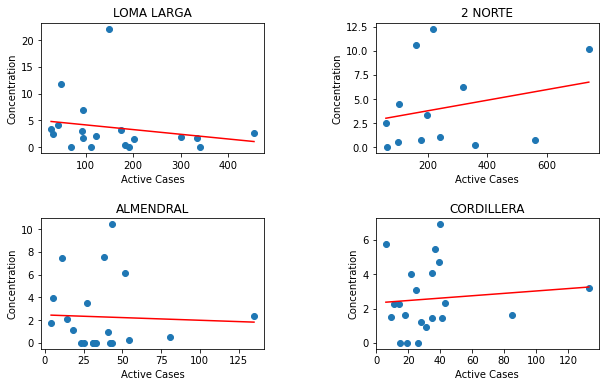

In [7]:
make_lin_reg('active_cases', 'concentration', 'Active Cases', 'Concentration')

*Looking at the linear regressions and the correlation coeeficient between concentration and active cases which is around 0.2 one can conclude that linear regression might not be a suitable model for explaining concentration. Another interesting observation is that in regions with less absolute active cases the majority of datapoints lies in the lower parts of the range whereas with higher case numbers the distribution is a bit more even albeit still skewed. Selecting and making a linear model for a subset of active cases might improve quality of regression especially in Cordillera.*

#### Make non-linear regressions


Non-linear Regressions with the data: LOMA LARGA


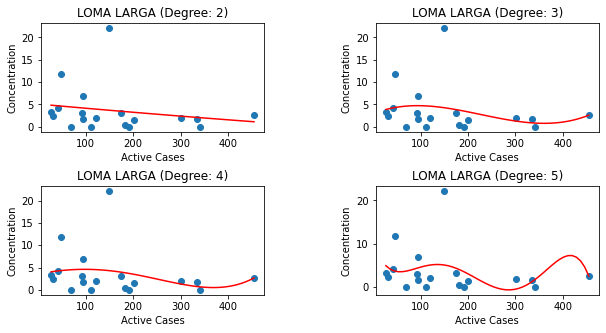


Non-linear Regressions with the data: 2 NORTE


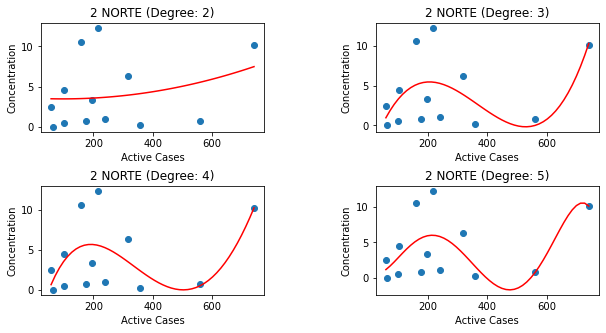


Non-linear Regressions with the data: ALMENDRAL


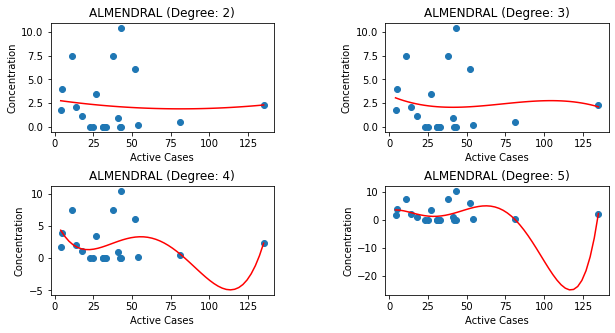


Non-linear Regressions with the data: CORDILLERA


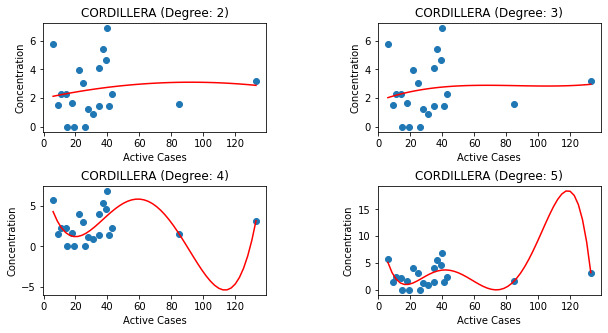

In [8]:
make_non_lin_reg('active_cases', 'concentration', 'Active Cases', 'Concentration', [2,3,4,5])

*The most plausible non linear regressions for all regions are of degree 2 and 3. Polynomials of higher degree display major signs of overfitting indicating that the underlying distribution lies in a complexity range of polynomials between degree 1 and 3.*

#### Would quality of linear regression increase, if we replace dependent variable "ActiveCases" by variable "ActiveIncidenceRate"?

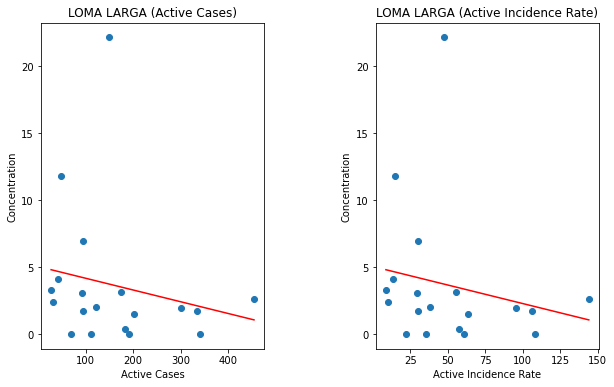

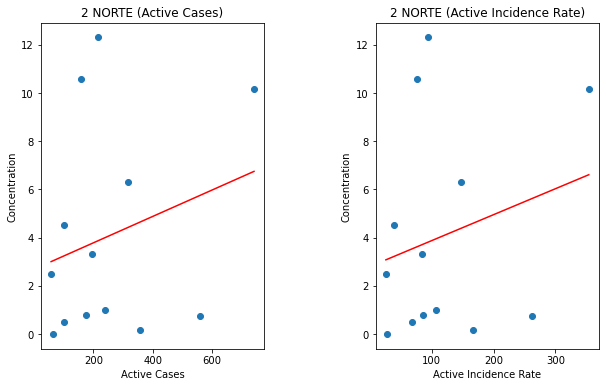

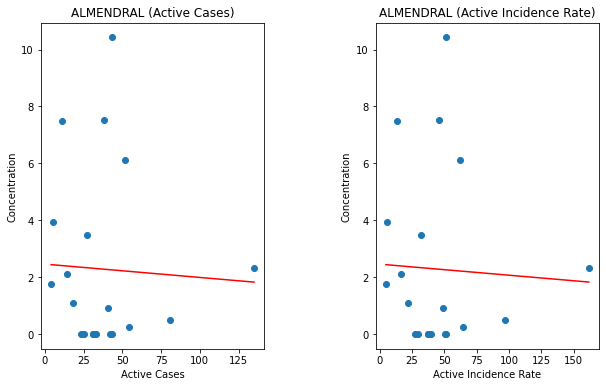

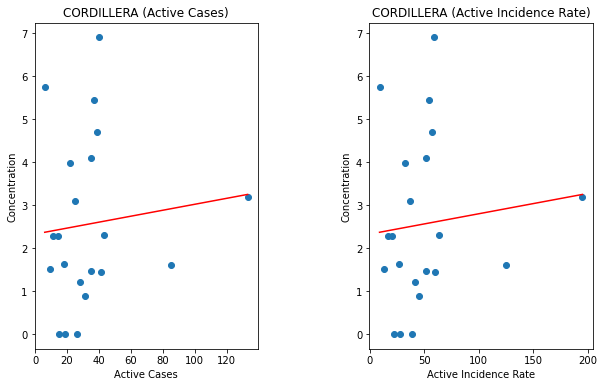

In [9]:
replace_dep('active_cases', 'active_incidence', 'concentration', 'Active Cases', 'Active Incidence Rate', 'Concentration')

*In this side to side comparisons we see that the quality would not increase if we replace dependent variable "ActiveCases" by variable "ActiveIncidenceRate". This is quite obvious when looking at correlations since active incidence rate has pretty much the same correlation with concentration as active cases.*

#### Make a comparison between plausible models

*Comparing models of degree 1-3 one can conclude that models of degree 2 or 3 can fit the cluster of datapoints in the lower case range better while still fitting higher points. When thinking about the problem purely intuitively, a linear relationship between active covid cases and virus concentrations in water makes the most sense. Also since models of higher degree fit regions with higher and lower datapoint densities they probably just fit to the noise in the data.*

#### Are residuals normally distributed?

In [10]:
print_residual_analysis()

The True/False value says, if the null hypothesis should be rejected by the majority vote of five tests for normal distribution
If "True" we can reject the hypothesis that the data is normally distributed and can say that is not normally distributed.
(With alpha = 0.05)

Linear regression Active Cases --> Concentration: LOMA LARGA: Rejection: True
Linear regression Active Cases --> Concentration: 2 NORTE: Rejection: False
Linear regression Active Cases --> Concentration: ALMENDRAL: Rejection: True
Linear regression Active Cases --> Concentration: CORDILLERA: Rejection: False
Non linear regression (degree: 2) Active Cases --> Concentration: LOMA LARGA: Rejection: True
Non linear regression (degree: 3) Active Cases --> Concentration: LOMA LARGA: Rejection: True
Non linear regression (degree: 4) Active Cases --> Concentration: LOMA LARGA: Rejection: True
Non linear regression (degree: 5) Active Cases --> Concentration: LOMA LARGA: Rejection: True
Non linear regression (degree: 2) Active C

*Testing for normality of residuals results in a rejection of the normality assumption for 2 of the four regions. Interestingly this is consistent for all models of degree 1-5 indicating that none of the proposed models are able to properly fit the data. Since different regions might have different factors influencing the underlying distribution it does make sense that in some regions model assumptions are satisfied and in others not but the fact that the normality of residuals is consistent for all models indicates that the data does not carry enough information to draw any positive conclusions.*

#### Are there outliers?

*As stated before in regions with lower absolute cases the datapoint density is higher in the lower range with hihger outliers. But there are also outliers with high concentraions at lower active cases, most prominently in Loma Larga. Overall though the data is very noisy so the relative distance of outliers from the rest of the data is not too large.*

#### Would adding of more secondary variables lead to a significantly improved regression?

*Since the correlation coefficients between concentration and all other variables are the same around 0.2 adding more of these variables would not improve regression because the linear relationship would not become stronger.*

## Task 3   
Study the dependence of: $~~~~~~~~~~$ ActiveCases = $f_1$(Concentration)   
- First make linear regression   
- Is the linear regression plausible? If not, suggest a non linear regression.   
- Would quality of linear regression increase, if we replace independent variable "ActiveCases" by variable "ActiveIncidenceRate"? 
- Would quality of linear regression increase, if we replace independent variable "ActiveCases" by variable "ActualCases"? 
- Make a comparison between plausible models.   
- Are residuals normally distributed?   
- Are there outliers?    
- Would adding of more secondary variables lead to a significantly improved regression?

#### Make a linear Regression

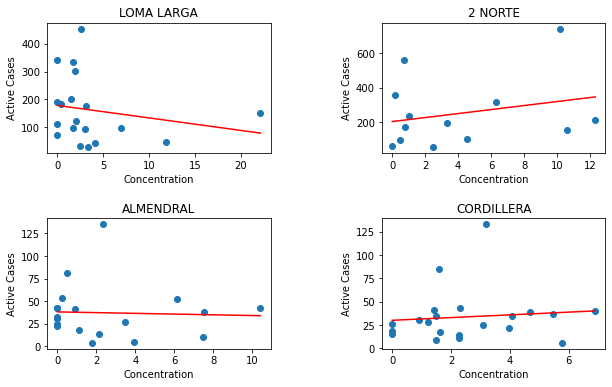

In [11]:
make_lin_reg('concentration', 'active_cases', 'Concentration', 'Active Cases')

At the first glance linear regressions look better and more plausible than in task 1. This visual effect is probably caused by difference in axis scales though, especially when looking at the normality of residuals.

#### Make non-linear regressions


Non-linear Regressions with the data: LOMA LARGA


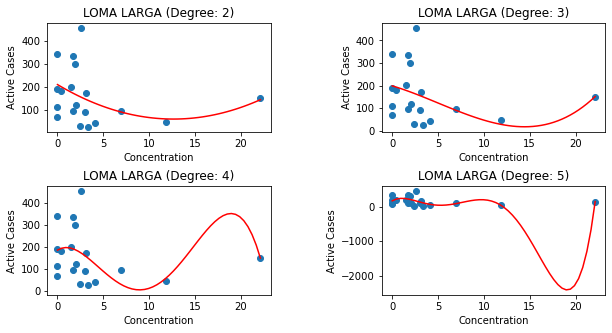


Non-linear Regressions with the data: 2 NORTE


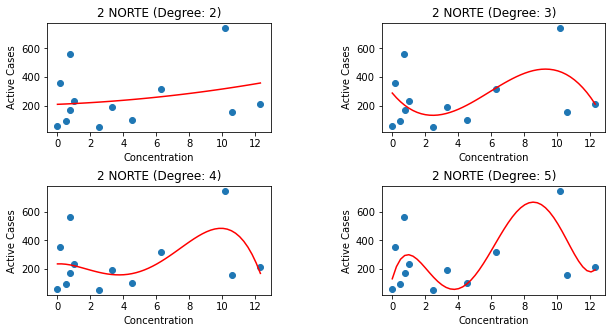


Non-linear Regressions with the data: ALMENDRAL


C:\Users\Peinthi\anaconda3\envs\CompStat\lib\site-packages\scipy\stats\stats.py:6707: RuntimeWarning: divide by zero encountered in true_divide
  terms = (f_obs_float - f_exp)**2 / f_exp


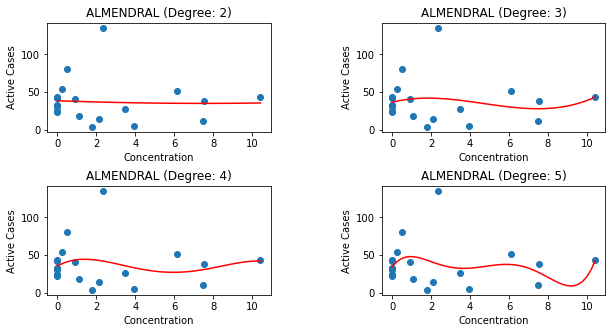


Non-linear Regressions with the data: CORDILLERA


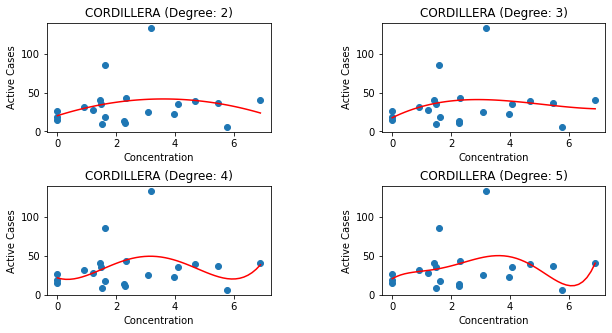

In [12]:
make_non_lin_reg( 'concentration', 'active_cases', 'Concentration', 'Active Cases', [2,3,4,5])

Again the most plausible non linear regressions are of degree 2 and 3 with higher degrees overfitting. Once more because of the high noise in the data even models of degree of 2 and 3 most likely just fit the random oise in the data better.

#### Would quality of linear regression increase, if we replace independent variable "ActiveCases" by variable "ActiveIncidenceRate"? 

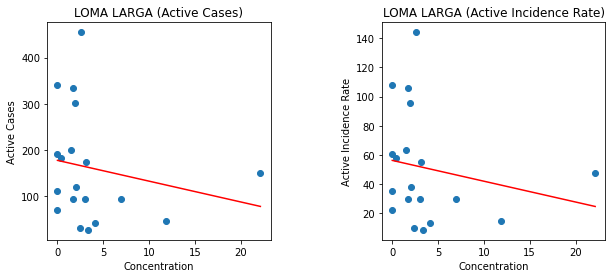

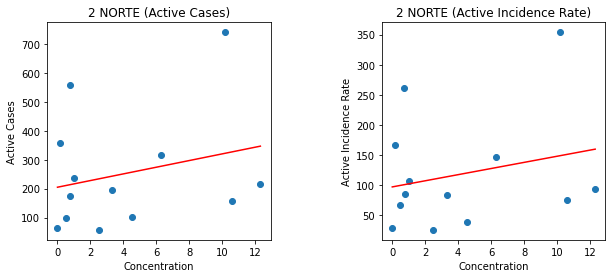

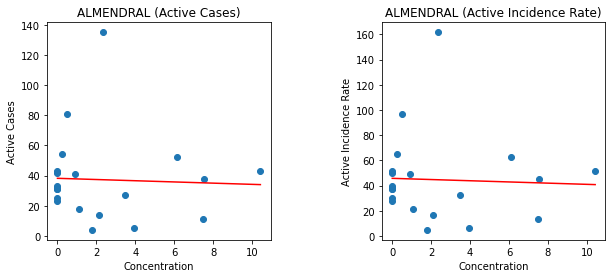

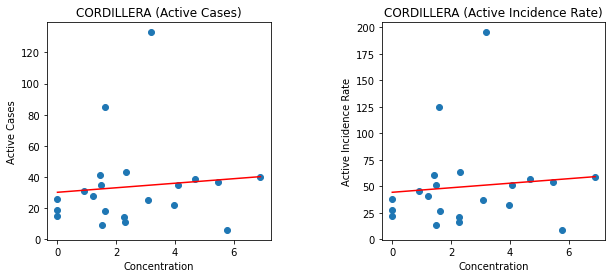

In [13]:
replace_indep('concentration', 'active_cases', 'active_incidence', 'Concentration', 'Active Cases', 'Active Incidence Rate')

At first the plots beside each other look identical but there is a difference in the y-axis. This difference leads also to different squared losses of the models and therefore to a better or worse fit.  
   
But the fits look to be close to identical anyway...so overall one cannot conclude that active incidence rate fits the data better which is consistent with its correlation coefficient.

#### Would quality of linear regression increase, if we replace independent variable "ActiveCases" by variable "ActualCases"?

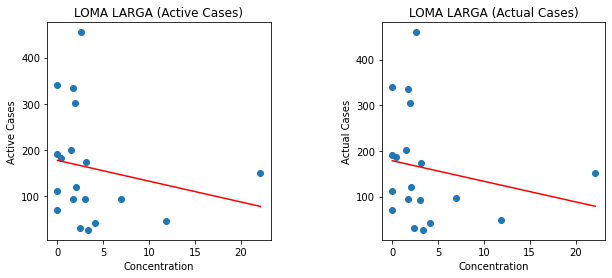

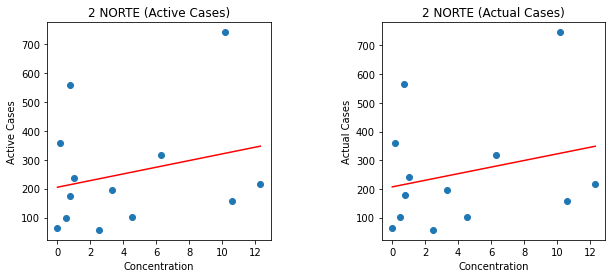

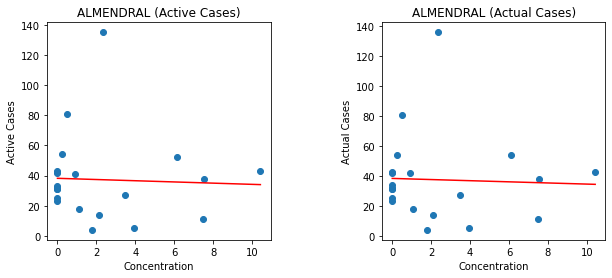

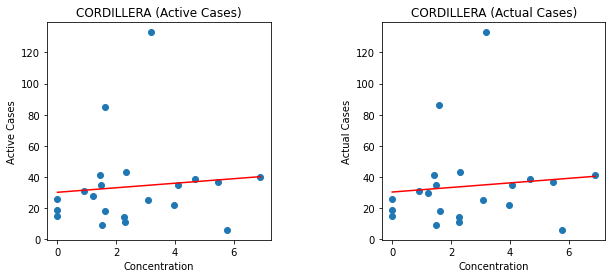

In [14]:
replace_indep('concentration', 'active_cases', 'actual_cases', 'Concentration', 'Active Cases', 'Actual Cases')

Overall the plots for both active and actual cases look identical so choosing either variable does not make a noticable difference. If actual cases is data that is cleaned of false positives then it would not make a difference since the test have a consistent false positive rate leading to a linear relationship between actual and active cases. If actual cases is just the properly cleaned data then quality of regression would improve marginally.

### Make a comparison between plausible models.

As in task 1 it looks like higher degree models just fit the noise in the data better than a linear model. Of note though is that the normality tests for higher degrees are rejected less than the linear case. So just looking at the numbers non linear models seem to fit the data better. This is still quite indecisive though and could very well entirely be due to chance.

### Are residuals normally distributed? 

In [15]:
print_residual_analysis()

The True/False value says, if the null hypothesis should be rejected by the majority vote of five tests for normal distribution
If "True" we can reject the hypothesis that the data is normally distributed and can say that is not normally distributed.
(With alpha = 0.05)

Linear regression Concentration --> Active Cases: LOMA LARGA: Rejection: False
Linear regression Concentration --> Active Cases: 2 NORTE: Rejection: True
Linear regression Concentration --> Active Cases: ALMENDRAL: Rejection: True
Linear regression Concentration --> Active Cases: CORDILLERA: Rejection: True
Non linear regression (degree: 2) Concentration --> Active Cases: LOMA LARGA: Rejection: False
Non linear regression (degree: 3) Concentration --> Active Cases: LOMA LARGA: Rejection: True
Non linear regression (degree: 4) Concentration --> Active Cases: LOMA LARGA: Rejection: False
Non linear regression (degree: 5) Concentration --> Active Cases: LOMA LARGA: Rejection: False
Non linear regression (degree: 2) Concen

For linear regressions the normalilty assumptions are rejected for 3 of the 4 regions so one can conclude that predicting concentration in terms of case numbers works even worse than the inverse case. Non linear regressions are not all rejected in regions Loma Larga and 2 Norte. More likely than not this is due to chance though and does not indicate an actually correct model.

### Are there outliers?

Again becauses axes are just swapped between task 1 there are the same outlier datapoints as before.

### Would adding of more secondary variables lead to a significantly improved regression?

Because active cases, actual cases and active incidence rate are linearly correlated with an coefficient of around 1 adding any of these secondary variables would significantly improve linear regression albeit not being particularilly useful since explaining one variable in terms of a directly related one is trivial.

## Task 4
Study the dependence of: $~~~~~~~~~~$ Concentration = $f_1$(ActiveCases, ActualCases)   
- First make linear regression  
- Is the linear regression plausible? If not, suggest a non linear regression.   
- Make a comparison between plausible models.
- Are residuals normally distributed?
- Are there outliers?
- Would adding of more secondary variables lead to a significantly improved regression?

### Make linear regression  

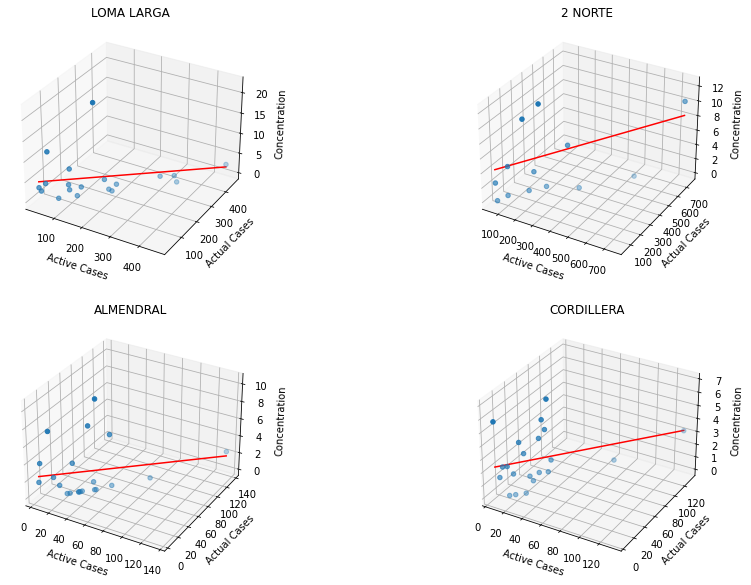

In [16]:
make_2d_lin_reg('active_cases', 'actual_cases', 'concentration', 'Active Cases', 'Actual Cases', 'Concentration')

The regressions seem pretty much the same as in the univariate case. But this makes sense, since the input vectors of X (Active Cases and Actual Cases) are highly correlated.

### Is the linear regression plausible?

Intuitively a linear relatioship between concentration and cases is plausible. This Theory is not supported by the data though since normailty tests are inconclusive. Because there is major multicollinearity between the explanatory variables they essentially measure the same phenomenon and therefore do not improve the model quality which can also be observed in the plot because the points still lie on a 2 dimensional plane and are not further separated by adding the third dimension.

### Suggest a non linear regression.


Non-linear Regressions with the data: LOMA LARGA


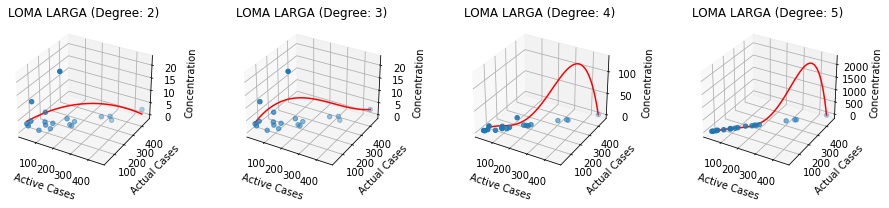


Non-linear Regressions with the data: 2 NORTE


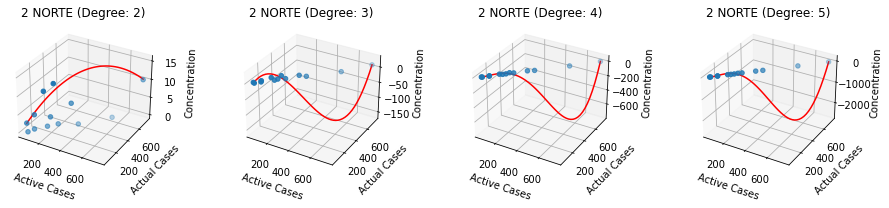


Non-linear Regressions with the data: ALMENDRAL


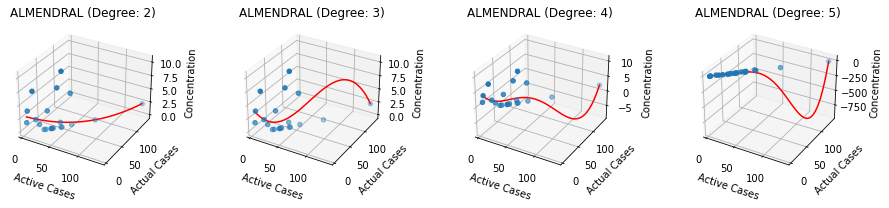


Non-linear Regressions with the data: CORDILLERA


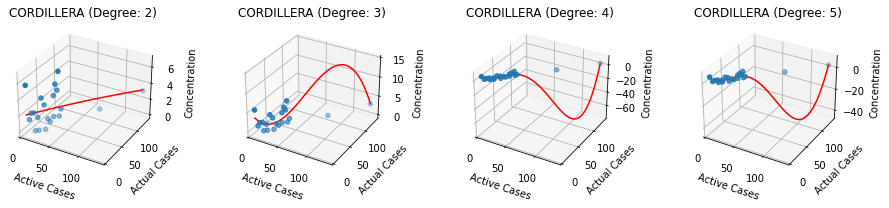

In [17]:
make_2d_non_lin_reg('active_cases', 'actual_cases', 'concentration', 'Active Cases', 'Actual Cases', 'Concentration', [2,3,4,5])

### Make a comparison between plausible models.

While the lower degree models seem to look somewhat plausible, or at least arguable, the higher degree fits seem to just be fitting towards heavy outliers. 
This is even more strange, when looking at the residual analysis, where indeed higher order polynomials tend to have normally distributed residuals more often. Also there seem to be some complete trend reversals regarding the normality tests, compared to the univariate cases in tasks 2 and 3.

### Are residuals normally distributed?

In [18]:
print_residual_analysis()

The True/False value says, if the null hypothesis should be rejected by the majority vote of five tests for normal distribution
If "True" we can reject the hypothesis that the data is normally distributed and can say that is not normally distributed.
(With alpha = 0.05)

Linear regression (Active Cases, Actual Cases) --> Concentration: LOMA LARGA: Rejection: True
Linear regression (Active Cases, Actual Cases) --> Concentration: 2 NORTE: Rejection: False
Linear regression (Active Cases, Actual Cases) --> Concentration: ALMENDRAL: Rejection: True
Linear regression (Active Cases, Actual Cases) --> Concentration: CORDILLERA: Rejection: False
Polynomial regression (degree: 2) (Active Cases, Actual Cases) --> Concentration: LOMA LARGA: Rejection: True
Polynomial regression (degree: 3) (Active Cases, Actual Cases) --> Concentration: LOMA LARGA: Rejection: True
Polynomial regression (degree: 4) (Active Cases, Actual Cases) --> Concentration: LOMA LARGA: Rejection: True
Polynomial regression (d

Because of the heavy multicollinearity of explanatory variables residuals of the multiple regression model are still not normally distributed and very similar to the first task.

### Are there outliers?

Adding a 1 to 1 correlated explanatory variable does not change anything about the outliers therefore following the same pattern as in previous tasks.

### Would adding of more secondary variables lead to a significantly improved regression?

Adding even more variables would again not improve regression quality since all variables other than concentration are correlated 1 to 1.